# I. Import necessary tools

In [666]:
## import libraries
import numpy as np # for numerical manipulation
import pandas as pd # for data structure processing
import matplotlib.pyplot as plt # for data visualization
import geopandas as gpd # for map rendition

# II. Useful custom functions and classes

## 1. Functions for data manipulation

In [667]:
# make functions to fill empty cells
def look_up_col(data, row, col):
    # search up a column until reaching an entry that's not NaN
    i = 0
    while data[row - i, col] != data[row - i, col]:
        i = i + 1
    return data[row - i, col]

def look_up_row(data, row, col):
    # search up a row until reaching an entry that's not NaN
    i = 0
    while data[row, col - 1] != data[row, col - 1]:
        i = i + 1
    return data[row, col - 1]

## 2. Functions and classes for administrative data filling

In [668]:
# make functions to enter demographics data
# compatible with the form of the 'data' variable, but not usable elsewhere
def fill_demographics(data, row):
    # demographics will be inputted as a 16-long binary-coded list:
    # 1st level = Christian (0) or non-Christian (8),
    # 2nd level = urban (0) or rural (4),
    # 3rd level = male (0) or female (2),
    # 4th level = Kinh (0) or minorities (1)
    demographics = np.zeros(16)
    for i in range(7, data.shape[1]):
        # check data point at column i
        if data[row, i] != data[row, i]:
            pass
        else:
            if (data[3, i] == '02. Công giáo') or (data[3, i] == '03. Tin Lành') or (data[3, i] == '14. Giáo hội Các thành hữu Ngày sau của Chúa Giê su Ky tô (Mormon)') or (data[3, i] == '16. Giáo hội Cơ đốc Phục lâm Việt Nam'):
                if data[0, i] == '1. Thành thị':
                    if data[1, i] == '1. Nam':
                        if data[2, i] == '01. Kinh':
                            demographics[0] += int(data[row, i])
                        else:
                            demographics[1] += int(data[row, i])
                    else:
                        if data[2, i] == '01. Kinh':
                            demographics[2] += int(data[row, i])
                        else:
                            demographics[3] += int(data[row, i])
                else:
                    if data[1, i] == '1. Nam':
                        if data[2, i] == '01. Kinh':
                            demographics[4] += int(data[row, i])
                        else:
                            demographics[5] += int(data[row, i])
                    else:
                        if data[2, i] == '01. Kinh':
                            demographics[6] += int(data[row, i])
                        else:
                            demographics[7] += int(data[row, i])
            elif data[3, i] == data[3, i]:
                if data[0, i] == '1. Thành thị':
                    if data[1, i] == '1. Nam':
                        if data[2, i] == '01. Kinh':
                            demographics[8] += int(data[row, i])
                        else:
                            demographics[9] += int(data[row, i])
                    else:
                        if data[2, i] == '01. Kinh':
                            demographics[10] += int(data[row, i])
                        else:
                            demographics[11] += int(data[row, i])
                else:
                    if data[1, i] == '1. Nam':
                        if data[2, i] == '01. Kinh':
                            demographics[12] += int(data[row, i])
                        else:
                            demographics[13] += int(data[row, i])
                    else:
                        if data[2, i] == '01. Kinh':
                            demographics[14] += int(data[row, i])
                        else:
                            demographics[15] += int(data[row, i])

    return demographics

In [669]:
# create class of administrative units
class admin_unit:
    def __init__(self, province, name, constituency, demographics):
        self.province = province
        self.name = name
        self.constituency = constituency
        self.demographics = demographics

## 3. Functions and classes for political parties

In [670]:
# class for political parties
class party:
    def __init__(self, code, name, theme_color, letter_color):
        self.code = code
        self.name = name
        self.theme_color = theme_color
        self.letter_color = letter_color

## 4. Functions and classes for constituency simulation

In [671]:
# class for constituencies
class constituency:
    def __init__(self, code, name, party):
        self.code = code
        self.name = name
        self.party = party

### a. Assign number of seats to constituencies

In [672]:
# function to assign number of seats to constituencies
def seat_count_assign(population):
    if population <= 200000:
        return 1
    elif population <= 400000:
        return 2
    else:
        return -((population - 400000) // -150000) + 2

### b. Assign seats in constituency to parties

In [673]:
# function for D'Hondt algorithm
def dhondt(total_seats, tally):
    '''Parameter: 
        total_seats (int) - number of total seats
        tally (list of floats) - number of votes for each party
    '''
    temp_tally = np.zeros(len(tally))
    for i in range(len(tally)):
        temp_tally[i] = tally[i]
    seats = np.zeros(len(temp_tally))
    for i in range(total_seats):
        seats[np.argmax(temp_tally)] += 1
        temp_tally[np.argmax(temp_tally)] = tally[np.argmax(temp_tally)] / (seats[np.argmax(temp_tally)] + 1) # this division makes D'Hondt the algorithm it is
    
    return seats

In [674]:
# function for Sainte-Laguë
def saintelague(total_seats, tally):
    '''Parameter: 
        total_seats (int) - number of total seats
        tally (list of floats) - number of votes for each party
    '''
    temp_tally = np.zeros(len(tally))
    for i in range(len(tally)):
        temp_tally[i] = tally[i]
    seats = np.zeros(len(temp_tally))
    for i in range(total_seats):
        seats[np.argmax(temp_tally)] += 1
        temp_tally[np.argmax(temp_tally)] = tally[np.argmax(temp_tally)] / (seats[np.argmax(temp_tally)] * 2 + 1) # this division makes Sainte-Laguë the algorithm it is
    
    return seats

### c. Calculate ideological distance

## 5. Functions for visualization

In [675]:
# generate parliamentary seating
# credit to https://github.com/titouanlegourrierec/Hemicycle-Chart/blob/main/chart.ipynb
def plot_parliamentary_seats(title, parties):
    from collections import namedtuple, defaultdict
    NUM_ROWS = 12
    INITIAL_RADIUS = 30
    RADIUS_INCREMENT = 5
    POINT_SIZE = 100

    def calculate_radius(num_rows, initial_radius, radius_increment):
        return [initial_radius + i * radius_increment for i in range(num_rows)]

    def calculate_arc_lengths(radius):
        return [r * np.pi for r in radius]

    def calculate_deputies_per_row(num_deputies, arc_lengths, total_arc_length):
        deputies_per_row = [int(num_deputies * (arc_length / total_arc_length)) for arc_length in arc_lengths]

        # Distribute the remaining deputies
        diff = num_deputies - sum(deputies_per_row)
        deputies_per_row[-1] += diff
        return deputies_per_row

    def generate_points(num_rows, radii, deputies_per_row):
        points = []
        for row in range(num_rows):
            radius = radii[row]
            num_deputies_row = deputies_per_row[row]
            angles = np.linspace(0, np.pi, num_deputies_row)
            x = radius * np.cos(angles)
            y = radius * np.sin(angles)
            for i in range(num_deputies_row):
                points.append((radius, angles[i], x[i], y[i]))
        return sorted(points, key=lambda x: x[1], reverse=True)
    
    def mainlist(num_rows, initial_radius, radius_increment, parties):
        num_deputies = 0
        for i in range(len(parties)):
            num_deputies += parties[i].total_seats
        radius = calculate_radius(num_rows, initial_radius, radius_increment)
        arc_lengths = calculate_arc_lengths(radius)
        total_arc_length = sum(arc_lengths)
        deputies_per_row = calculate_deputies_per_row(num_deputies, arc_lengths, total_arc_length)
        points = generate_points(num_rows, radius, deputies_per_row)

        Deputy = namedtuple('Deputy', ['x', 'y', 'radius', 'angle'])
        return [Deputy(x, y, radius, angle) for (radius, angle, x, y) in points]

    def plot_deputies(deputies, parties, POINT_SIZE, title):
        """Plot the deputies on a chart.
        
        Parameters:
            - deputies (list): The list of deputies.
            - parties (list): The list of parties."""
        deputies_by_party = defaultdict(list)

        current_index = 0

        for party in parties:
            party_deputies = deputies[current_index:current_index + party.total_seats]
            deputies_by_party[party.code].extend(party_deputies)
            current_index += party.total_seats

        deputies_by_party = dict(deputies_by_party)

        plt.figure(figsize=(12, 6))

        for party in parties:
            color = party.theme_color
            party_deputies = deputies_by_party[party.code]

            label = party.code

            for deputy in party_deputies:
                if color == 'unassigned':
                    plt.scatter(deputy.x, deputy.y, s=POINT_SIZE, facecolors='none', edgecolors='grey', linewidth=0.75, label=label)
                else:
                    plt.scatter(deputy.x, deputy.y, s=POINT_SIZE, alpha=1, color = color, label=label)

                label = ""

        plt.gca().set_aspect('equal')
        plt.axis('off')

        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0) , ncol=6, frameon=False)
        plt.suptitle(title)

        plt.show()

    deputies = mainlist(NUM_ROWS, INITIAL_RADIUS, RADIUS_INCREMENT, parties)
    plot_deputies(deputies, parties, POINT_SIZE, title)

# III. Data import and cleaning

## 1. Demographics massive dataset
Stable output: data

In [676]:
# import massive dataset
data = pd.read_csv("Massive Dataset.csv")

/var/folders/lc/09gpt2x95kz9p9z4gngg9g9c0000gn/T/ipykernel_49660/3828475198.py:2: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

In [677]:
# clean data
data = data[~data.iloc[:, 0].str.contains('(Tổng số)', case=False, na=False)]

data = np.array(data)

for i in range(4, len(data[0, :])):
    # fill urban/rural row
    if data[0, i] != data[0, i]:
        data[0, i] = data[0, i - 1]

for i in range(5, len(data[0, :])):
    # fill sex row
    if data[1, i] != data[1, i]:
        data[1, i] = data[1, i - 1]

for i in range(6, len(data[0, :])):
    # fill ethnicity row
    if data[2, i] != data[2, i]:
        data[2, i] = data[2, i - 1]

for i in range(len(data[:,1])):
    if data[i, 1] == data[i, 1]:
        data[i, 0] = look_up_col(data, i, 0)

pd.DataFrame(data)

/var/folders/lc/09gpt2x95kz9p9z4gngg9g9c0000gn/T/ipykernel_49660/4072390454.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data = data[~data.iloc[:, 0].str.contains('(Tổng số)', case=False, na=False)]


,0,1,2,3,4,5,6,7,8,9,...,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493
0,NaN,NaN,Constituency,Tổng số,1. Thành thị (Tổng số),1. Thành thị,1. Thành thị,1. Thành thị,1. Thành thị,1. Thành thị,...,2. Nông thôn,2. Nông thôn,2. Nông thôn,2. Nông thôn,2. Nông thôn,2. Nông thôn,2. Nông thôn,2. Nông thôn,2. Nông thôn,2. Nông thôn
1,NaN,NaN,NaN,NaN,NaN,1. Nam (Tổng số),1. Nam,1. Nam,1. Nam,1. Nam,...,2. Nữ,2. Nữ,2. Nữ,2. Nữ,2. Nữ,2. Nữ,2. Nữ,2. Nữ,2. Nữ,2. Nữ
2,NaN,NaN,NaN,NaN,NaN,NaN,01. Kinh (Tổng số),01. Kinh,01. Kinh,01. Kinh,...,55. Người nước ngoài,55. Người nước ngoài,55. Người nước ngoài,55. Người nước ngoài,55. Người nước ngoài,56.KXĐ (Tổng số),56.KXĐ,56.KXĐ,56.KXĐ,56.KXĐ
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Không tôn giáo,01. Phật giáo,02. Công giáo,...,03. Tin Lành,04. Cao Đài,06. Hồi giáo,13. Bà La Môn,16. Giáo hội Cơ đốc Phục lâm Việt Nam,NaN,Không tôn giáo,01. Phật giáo,02. Công giáo,16. Giáo hội Cơ đốc Phục lâm Việt Nam
4,Thành phố Hà Nội,Quận Ba Đình,HN-01,221893,221893,107074,106305,105402,376,513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,Tỉnh Cà Mau,Huyện Cái Nước,CM-05,136638,14482.0,7190.0,7153.0,7086.0,50.0,5.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
713,Tỉnh Cà Mau,Huyện Đầm Dơi,CM-06,175629,10476.0,5235.0,5198.0,5184.0,7.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
714,Tỉnh Cà Mau,Huyện Năm Căn,CM-07,56813,16477.0,8300.0,7967.0,7864.0,31.0,61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
715,Tỉnh Cà Mau,Huyện Phú Tân,CM-07,97703,13870.0,7019.0,6814.0,6729.0,23.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Demographics simplified dataset
Stable output: admin_units

In [678]:
# enter administrative unit data
admin_units = []

for i in range(len(data[:,1])):
    if data[i, 1] == data[i, 1]:
        admin_units.append(
            admin_unit(
                province = data[i, 0],
                name = data[i, 1],
                constituency = data[i, 2],
                demographics = fill_demographics(data, i)
            )
        )

In [679]:
# test dataset
# demographics will be inputted as a 16-long binary-coded list:
# 1st level = Christian (0) or non-Christian (8),
# 2nd level = urban (0) or rural (4),
# 3rd level = male (0) or female (2),
# 4th level = Kinh (0) or minorities (1)
for i in range(710):
    print(admin_units[i].constituency)

HN-01
HN-02
HN-03
HN-04
HN-05
HN-06
HN-07
HN-08
HN-09
HN-10
HN-11
HN-12
HN-13
HN-14
HN-15
HN-16
HN-17
HN-18
HN-19
HN-20
HN-21
HN-22
HN-23
HN-24
HN-25
HN-26
HN-27
HN-28
HN-29
HN-30
HG-01
HG-02
HG-02
HG-03
HG-03
HG-04
HG-01
HG-05
HG-05
HG-06
HG-06
CB-01
CB-02
CB-02
CB-03
CB-03
CB-03
CB-03
CB-04
CB-04
CB-04
CB-01
CB-02
CB-04
BK-01
BK-02
BK-02
BK-02
BK-01
BK-02
BK-01
BK-01
TQ-01
TQ-02
TQ-02
TQ-02
TQ-03
TQ-04
TQ-05
LC-01
LC-02
LC-03
LC-03
LC-03
LC-04
LC-05
LC-02
LC-05
DB-01
DB-03
DB-05
DB-03
DB-03
DB-04
DB-02
DB-01
DB-04
DB-05
LI-01
LI-01
LI-02
LI-02
LI-01
LI-03
LI-03
LI-02
SL-01
SL-02
SL-03
SL-02
SL-04
SL-05
SL-06
SL-04
SL-07
SL-08
SL-08
SL-06
YB-01
YB-02
YB-03
YB-04
YB-02
YB-01
YB-02
YB-05
YB-06
HO-01
HO-02
HO-03
HO-03
HO-04
HO-02
HO-05
HO-05
HO-06
HO-07
HO-07
TY-01
TY-02
TY-03
TY-03
TY-04
TY-04
TY-05
TY-02
TY-06
LS-01
LS-02
LS-03
LS-02
LS-05
LS-05
LS-03
LS-04
LS-05
LS-05
LS-05
QN-01
QN-02
QN-03
QN-04
QN-05
QN-06
QN-05
QN-05
QN-06
QN-06
QN-01
QN-07
QN-08
QN-09
BG-01
BG-02
BG-03
BG-04
BG-0

## 3. Constituency map dataset
Stable output: map_data

In [680]:
# import map of constituencies
map_data = gpd.read_file('full-map-8.json')

## 4. Party dataset
Stable output: parties, partypd

In [681]:
# import party dataset
partypd = pd.read_csv("party.csv")
partypd = np.array(partypd)

parties = []
for i in range(len(partypd[:, 0])):
    parties.append(
        party(
            code = partypd[i, 0],
            name = partypd[i, 1],
            theme_color = partypd[i, 2],
            letter_color = partypd[i, 3]
        )
    )

# IV. Simulation

## 1. Votes per party by administrative unit

In [682]:
# initialize the voter tally in each admin unit
for i in range(len(admin_units)):
    admin_units[i].votes = np.zeros(len(parties))

admin_units[5].__dict__

{'province': ' Thành phố Hà Nội',
 'name': 'Quận Đống Đa',
 'constituency': 'HN-06',
 'demographics': array([9.78000e+02, 1.00000e+01, 1.12000e+03, 5.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.73200e+05, 1.43100e+03,
        1.91981e+05, 2.88100e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00]),
 'votes': array([0., 0., 0., 0., 0.])}

In [683]:
# initialize voter affinity for each party
for i in range(len(parties)):
    parties[i].voterpc = np.full(16, 0.05)

# TEST PROGRAM
# assign voter affinity for each party
# demographics will be inputted as a 16-long binary-coded list:
# 1st level = Christian (0) or non-Christian (8),
# 2nd level = urban (0) or rural (4),
# 3rd level = male (0) or female (2),
# 4th level = Kinh (0) or minorities (1)
for i in range(len(parties)):
    if parties[i].code == "CDP":
        parties[i].voterpc[0:8] = np.random.normal(0.2, 0.001) # all Christians prefer CDP
        parties[i].voterpc[8:15] = np.random.normal(0.03, 0.001) # all non-Christians distance from CDP
    elif parties[i].code == "LIB":
        parties[i].voterpc[8:12] = np.random.normal(0.055, 0.001) # all non-Christian urbanites prefer LIB - was 0.3
        parties[i].voterpc[12:15] = np.random.normal(0.07, 0.001) # all non-Christian rurals slightly prefer LIB
    elif parties[i].code == "COM":
        parties[i].voterpc[12:14] = np.random.normal(0.13, 0.001) # all non-Christian rural males prefer COM
    elif parties[i].code == "VIE":
        parties[i].voterpc[14] = np.random.normal(0.14, 0.001) # all non-Christian rural female Kinhs prefer VIE
    else:
        parties[i].voterpc[15] = np.random.normal(0.135, 0.001) # the rest prefer WPV

In [684]:
# allocate a number of voters to each party
for i in range(len(admin_units)): # iterate for all administrative units
    for j in range(len(admin_units[i].votes)): # iterate for all parties in each administrative units
        admin_units[i].votes[j] = np.dot(parties[j].voterpc, admin_units[i].demographics)

## 2. Votes per party by constituencies

In [685]:
# initialize list of constituencies
constituencies = []
map_datanp = np.array(map_data)

for i in range(len(map_data)):
    constituencies.append(
        constituency(
            code = map_datanp[i, 5],
            name = "",
            party = ""
        )
    )

In [686]:
# initialize voter tally in constituency
for i in range(len(constituencies)):
    constituencies[i].votes = np.zeros(len(parties))

# add up votes for each party from a constituency
for i in range(len(admin_units)):
    for j in range(len(constituencies)):
        if admin_units[i].constituency == constituencies[j].code:
            constituencies[j].votes = constituencies[j].votes + admin_units[i].votes

# assign winner to each constituency
for i in range(len(constituencies)):
    constituencies[i].party = parties[np.argmax(constituencies[i].votes)].name

In [687]:
map_data

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,seat,geometry
0,None,None,None,None,None,TT-05,"POLYGON ((107.1303 16.4481, 107.12914 16.44665..."
1,An Bien,,81297802B3825263519858,VNM,ADM2,KG-08,"POLYGON ((105.13699 9.82989, 105.13543 9.83234..."
2,An Lao,,81297802B65658789050233,VNM,ADM2,HP-08,"POLYGON ((106.54673 20.86854, 106.54619 20.868..."
3,An Minh,,81297802B42244354568951,VNM,ADM2,KG-09,"POLYGON ((104.91589 9.84754, 104.90461 9.85073..."
4,An Nhon,,81297802B14138193507010,VNM,ADM2,BD-07,"POLYGON ((109.17682 13.93818, 109.17705 13.939..."
...,...,...,...,...,...,...,...
501,None,None,None,None,None,HU-03,"POLYGON ((105.74177 9.96696, 105.7408 9.96762,..."
502,None,None,None,None,None,ST-02,"POLYGON ((105.9961 9.71042, 105.9947 9.71053, ..."
503,None,None,None,None,None,ST-04,"POLYGON ((106.07357 9.77441, 106.07209 9.77326..."
504,None,None,None,None,None,ST-06,"POLYGON ((105.54512 9.45049, 105.54698 9.44848..."


## 3. Seats per party by constituencies

In [688]:
# find population of each constituency
for i in range(len(constituencies)):
    constituencies[i].population = 0
    for j in range(len(admin_units)):
        if admin_units[j].constituency == constituencies[i].code:
            for k in range(len(admin_units[j].demographics)):
                constituencies[i].population = constituencies[i].population + admin_units[j].demographics[k]

In [689]:
# assign number of seats to each constituency
for i in range(len(constituencies)):
    constituencies[i].seat_count = seat_count_assign(constituencies[i].population)

In [690]:
# assign seat to party in each constituency
# currently using D'Hondt algorithm
for i in range(len(constituencies)):
    constituencies[i].seats = dhondt(int(constituencies[i].seat_count), constituencies[i].votes)

## 4. Total seats per party

In [691]:
# find total seat count of each party
# initialize total seat tally
for i in range(len(parties)):
    parties[i].total_seats = 0

# add up seat count for each party
for i in range(len(parties)):
    for j in range(len(constituencies)):
        parties[i].total_seats = parties[i].total_seats + constituencies[j].seats[i]
    parties[i].total_seats = int(parties[i].total_seats)

# V. Visualization

## 1. Maps

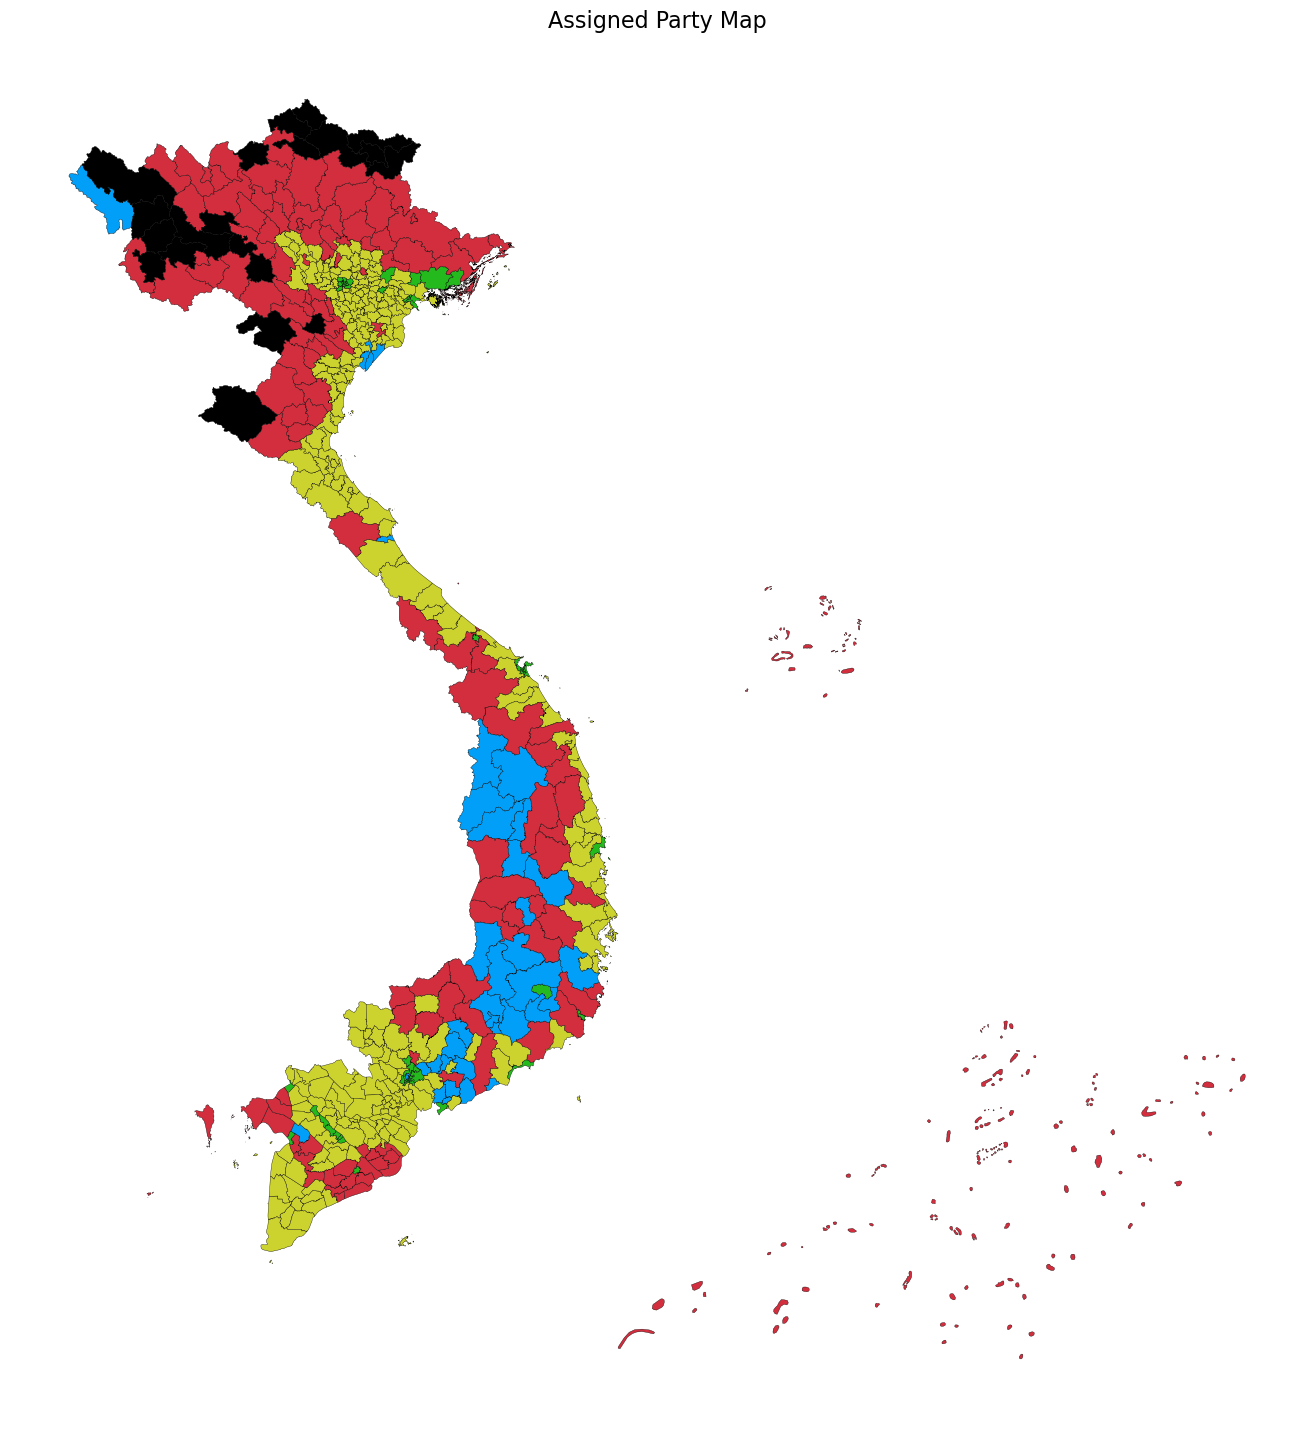

In [692]:
# plot map of all constituencies, colored by winning party
# give each constituency a color according to the winner party
color_set = partypd[:,2]
color_col = []

for i in range(len(map_data)): # iterate through each constituency on map
    for j in range(len(constituencies)): # iterate through each constituency on list
        if map_datanp[i, 5] == constituencies[j].code: # match constituency by code
            color_col.append(color_set[np.argmax(constituencies[j].votes)]) # assign color

map_data['color'] = color_col

# plot map
fig, ax = plt.subplots(figsize = (18, 18))
map_data.plot(ax = ax, color = map_data['color'], edgecolor = 'black', linewidth = 0.25)
ax.axis('off')
ax.set_title('Assigned Party Map', fontsize = 16)
plt.show()

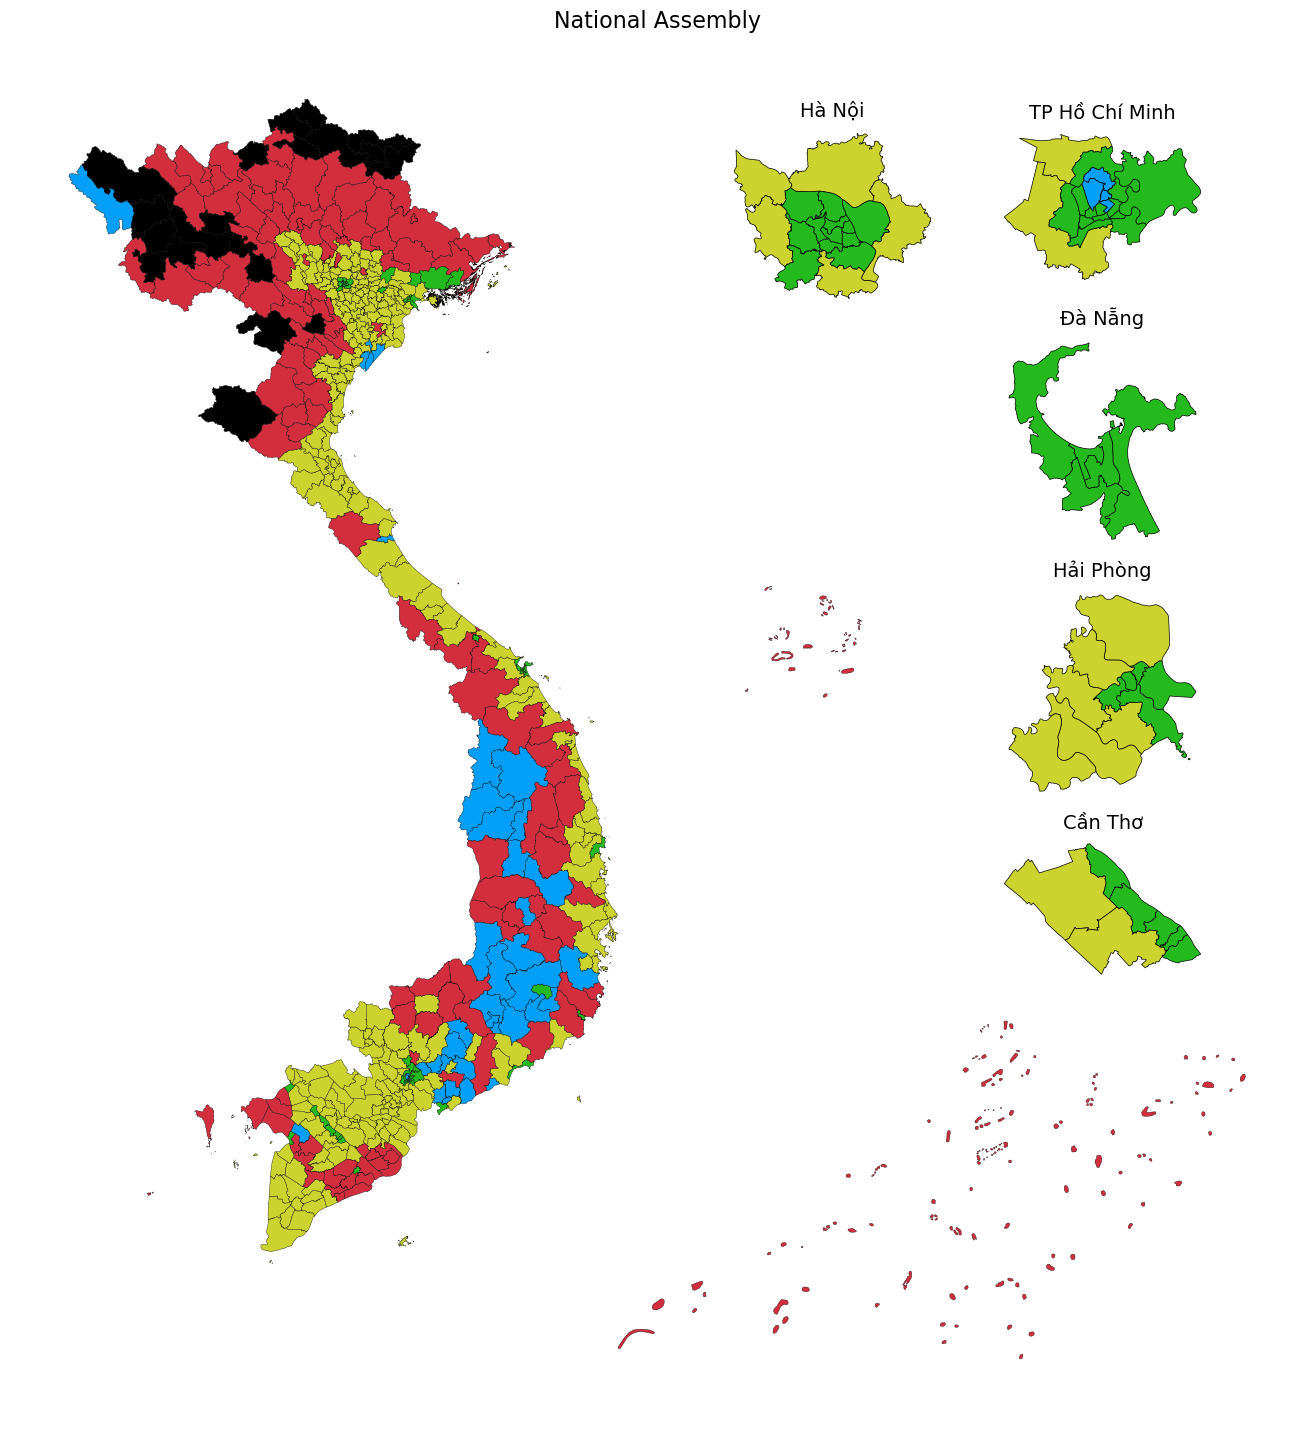

In [693]:
# mix plot
fig, ax = plt.subplots(figsize=(18, 18))
map_data.plot(ax=ax, color=map_data['color'], edgecolor='black', linewidth=0.25)
ax.set_title('National Assembly', fontsize=16)

## HCMC inset
HCMC_map_data = map_data[map_data['seat'].str.startswith(('SG-0', 'SG-10', 'SG-11', 'SG-12', 'SG-13', 'SG-14', 'SG-15', 'SG-16', 'SG-17', 'SG-19', 'SG-20'))]
HCMC_inset = fig.add_axes([0.7, 0.725, 0.12, 0.12]) # [x, y, width, height] in relative figure coordinates
HCMC_map_data.plot(ax=HCMC_inset, color=HCMC_map_data['color'], edgecolor='black', linewidth=0.5)
HCMC_inset.set_title('TP Hồ Chí Minh', fontsize=14)
HCMC_inset.axis('off')  # Remove axes for cleaner appearance

## HN inset
HN_map_data = map_data[map_data['seat'].str.startswith(('HN-0', 'HN-11', 'HN-12', 'HN-13', 'HN-14', 'HN-15', 'HN-17', 'HN-21', 'HN-22'))]
HN_inset = fig.add_axes([0.55, 0.72, 0.12, 0.12]) # [x, y, width, height] in relative figure coordinates
HN_map_data.plot(ax=HN_inset, color=HN_map_data['color'], edgecolor='black', linewidth=0.5)
HN_inset.set_title('Hà Nội', fontsize=14)
HN_inset.axis('off')  # Remove axes for cleaner appearance

## DA inset
DA_map_data = map_data[map_data['seat'].str.startswith(('DA-01', 'DA-02', 'DA-03', 'DA-04', 'DA-05'))]
DA_inset = fig.add_axes([0.7, 0.595, 0.12, 0.12]) # [x, y, width, height] in relative figure coordinates
DA_map_data.plot(ax=DA_inset, color=DA_map_data['color'], edgecolor='black', linewidth=0.5)
DA_inset.set_title('Đà Nẵng', fontsize=14)
DA_inset.axis('off')  # Remove axes for cleaner appearance

## HP inset
HP_map_data = map_data[map_data['seat'].str.startswith(('HP-0', 'HP-10', 'HP-11'))]
HP_inset = fig.add_axes([0.7, 0.455, 0.12, 0.12]) # [x, y, width, height] in relative figure coordinates
HP_map_data.plot(ax=HP_inset, color=HP_map_data['color'], edgecolor='black', linewidth=0.5)
HP_inset.set_title('Hải Phòng', fontsize=14)
HP_inset.axis('off')  # Remove axes for cleaner appearance

## CN inset
CN_map_data = map_data[map_data['seat'].str.startswith(('CN'))]
CN_inset = fig.add_axes([0.7, 0.335, 0.12, 0.12]) # [x, y, width, height] in relative figure coordinates
CN_map_data.plot(ax=CN_inset, color=CN_map_data['color'], edgecolor='black', linewidth=0.5)
CN_inset.set_title('Cần Thơ', fontsize=14)
CN_inset.axis('off')  # Remove axes for cleaner appearance

# Remove axes from the main map
ax.axis('off')

# Show the plot
plt.show()

(103.65568949330003,
 108.42755922670005,
 15.760585324000052,
 20.904483578000033)

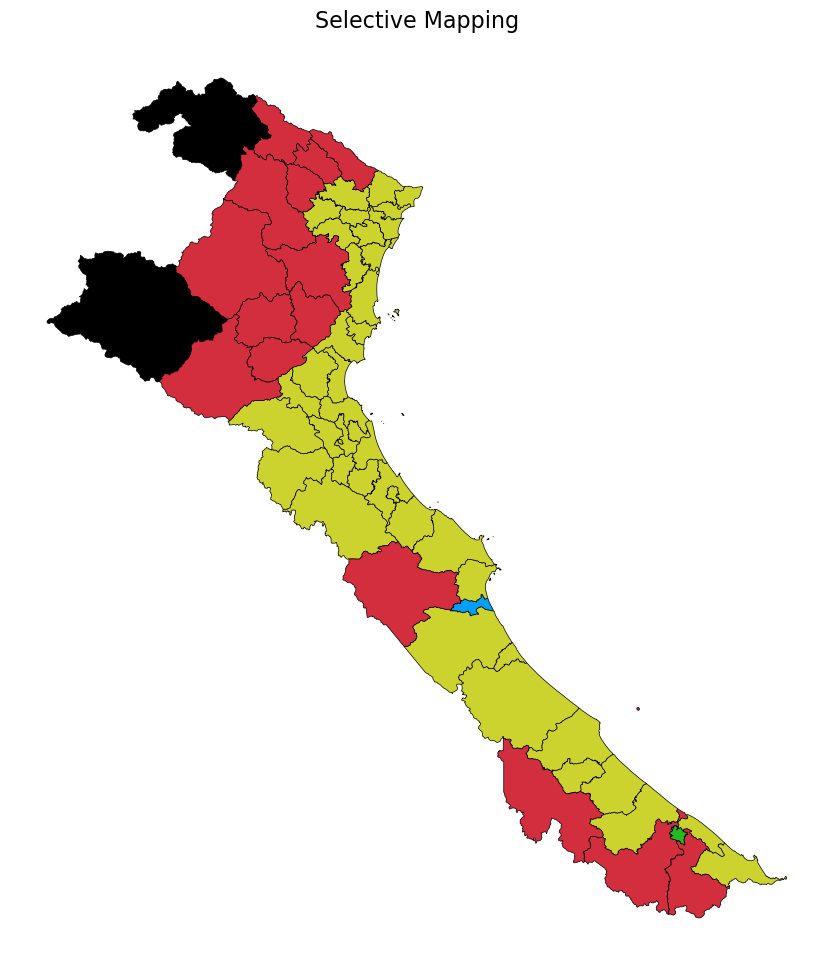

In [694]:
# selective mapping for your province of choice
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title('Selective Mapping', fontsize=16)

filtered_map_data = map_data[map_data['seat'].str.startswith(('TH', 'NA', 'HT', 'QB', 'QT', 'TT'))] # Enter the code of the province(s) or region you want to display
'''
Regions:
Northwest: ('LI', 'DB', 'LC', 'YB', 'SL', 'HO')
Northeast: ('HG', 'TQ', 'CB', 'BK', 'LS', 'TY', 'BG', 'QN', 'PT')
Red River Delta: ('VC', 'HN', 'HM', 'NB', 'ND', 'HY', 'BN', 'HD', 'HP', 'TB')
North Central: ('TH', 'NA', 'HT', 'QB', 'QT', 'TT')
South Central: ('DA', 'QM', 'QG', 'BD', 'PY', 'KH', 'NT', 'BU')
Southeast: ('TN', 'BI', 'BP', 'DN', 'SG', 'BV')
Southwest: ('LA', 'TG', 'BR', 'VL', 'TV', 'DT', 'CN', 'HU', 'ST', 'BL', 'AG', 'KG', 'CM')

Specials:
Da Nang without the Paracels: ('DA-01', 'DA-02', 'DA-03', 'DA-04', 'DA-05', 'DA-06')
Khanh Hoa without the Spratlies: ('KH-01', 'KH-02', 'KH-03', 'KH-04', 'KH-05', 'KH-06')
Red River Delta without Bạch Long Vĩ: ('VC', 'HN', 'HM', 'NB', 'ND', 'HY', 'BN', 'HD', 'TB', 'HP-0', 'HP-10', 'HP-11', 'HP-12')
Southeast without Côn Đảo: ('TN', 'BI', 'BP', 'DN', 'SG', 'BV-01', 'BV-02', 'BV-03', 'BV-04', 'BV-05', 'BV-06')
'''
filtered_map_data.plot(ax=ax, color=filtered_map_data['color'], edgecolor='black', linewidth=0.5)
ax.axis('off')  # Remove axes for cleaner appearance

## 2. Parliamentary charts

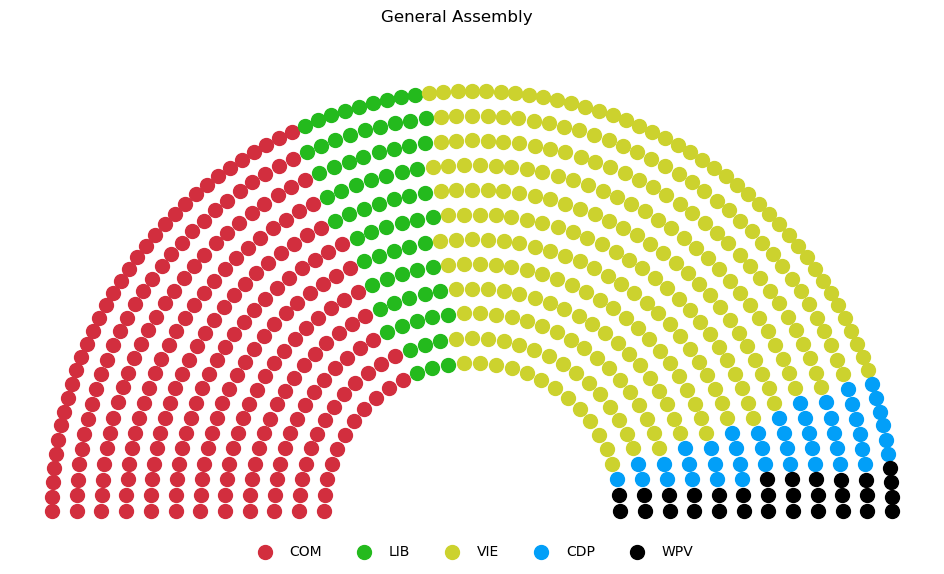

In [695]:
# National Assembly
plot_parliamentary_seats("General Assembly", parties)

In [696]:
for i in range(len(parties)):
    print(parties[i].total_seats)

252
72
300
44
31
